# Feature Engineering (user_logs)

In [2]:
# math library
import numpy as np
import pandas as pd
import seaborn as sns
import random
import datetime
from datetime import datetime as dt
from collections import Counter
from scipy.stats.stats import pearsonr # for pearson correlation

# visualization library
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png2x','pdf')
import matplotlib.pyplot as plt
#import mpld3
from pandas.plotting import scatter_matrix

# machine learning library
from sklearn.linear_model import LogisticRegression

# 3d visualization
from mpl_toolkits.mplot3d import axes3d

# computational time
import time

# 3. user_logs

In this part, we will look at the user_logs data separatly to try out tweaks on the features. Those changes will be applied if they yield a better result for our prediction.

## 3.1 Loading the data

Let's load 
- user_logs_feb: has input data from 2015-Jan17 and is_churn in Feb17
- user_logs_mar: has input data from 2015-Feb17 and is_churn in Mar17
- user_logs_apr: has input data from 2015-Mar17 and will be used to predict is_churn in Apr17. 

The files were created in a different notebook, called 'Loading_user_logs_FINAL'.

To test our prediction by ourselves, we can train on user_logs_feb and test on user_logs_mar, as we have the output label is_churn for both datasets.

In [3]:
# loading data
user_logs_feb = pd.read_csv('data/user_logs_feb.csv')
user_logs_mar = pd.read_csv('data/user_logs_mar.csv')
user_logs_apr = pd.read_csv('data/user_logs_apr.csv')

In [4]:
print(user_logs_feb.shape)
print(user_logs_mar.shape)
print(user_logs_apr.shape)

(992931, 21)
(970960, 21)
(907471, 21)


## 3.2 Testing Features and Algorithms

In [ ]:
# Loading machine learning library
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
import xgboost as xgb
from sklearn.grid_search import GridSearchCV
from sklearn.neural_network import MLPClassifier


### 3.3.1 Testing Prediction Models

Before changing the features, we will try out different prediction algorithms to get an idea of which one works best for our data. After running them on a 10% sample of our dataset, we will select the best ones and only use those to test our data with different features.

First, let's create sample with reduced size for testing purposes.

In [33]:
print(user_logs_feb.shape)
ul_1 = user_logs_feb.sample(frac=0.1)
print(ul_1.shape)

print(user_logs_mar.shape)
ul_2 = user_logs_mar.sample(frac=0.1)
print(ul_2.shape)


(992931, 21)
(99293, 21)
(970960, 21)
(97096, 21)


#### i) Linear Regression

In [34]:
# Linear Regression
def lin_reg(train,test):
    if ('msno' in train.columns):
        train = train.drop('msno',axis=1)
    if ('msno' in test.columns):
        test = test.drop('msno',axis=1)
    X_train = train.drop('is_churn',axis=1)
    y_train = train['is_churn']
    X_test = test.drop('is_churn',axis=1)
    y_test = test['is_churn']
    
    model_lin_reg = LinearRegression(normalize=True)
    model_lin_reg.fit(X_train, y_train)
    y_pred_l = model_lin_reg.predict(X_test)
    y_pred_l[y_pred_l<0] = 0
    print("Logloss for Linear Regression is: %.6f"%log_loss(y_test,y_pred_l))


In [35]:
lin_reg(ul_1,ul_2)
#lin_reg(user_logs_feb,user_logs_mar)
print('### over-fitting check: ###')
lin_reg(ul_2,ul_2)

Logloss for Linear Regression is: 0.304497
### over-fitting check: ###
Logloss for Linear Regression is: 0.299051


Linear Regression returns a log_loss score of around 0.30. When we test our prediction on the data we trained it on, we also get 0.30 - which let's us conclude that there is no over-fitting.

#### ii) Random Forrest

The third argument of the function, 'importance', will make the function return a ordered list of the most important features if set to 1.

In [36]:
# Run Forest
def ran_for(train,test,importance):
    start = time.time()
    if ('msno' in train.columns):
        train = train.drop('msno',axis=1)
    if ('msno' in test.columns):
        test = test.drop('msno',axis=1)
    X_train = train.drop('is_churn',axis=1)
    y_train = train['is_churn']
    X_test = test.drop('is_churn',axis=1)
    y_test = test['is_churn']
    
    model_Forest = RandomForestRegressor()
    model_Forest.fit(X_train, y_train)
    y_pred_f = model_Forest.predict(X_test)
    print("Logloss for Random Forrest is: %.6f"%log_loss(y_test,y_pred_f))
    
    if (importance == 1):
        importances = model_Forest.feature_importances_
        indices = np.argsort(importances)[::-1]
        columns = np.array(list(X_train))
        
        # Print the feature ranking
        print("\nFeature ranking:")
        
        for f in range(X_train.shape[1]):
            print("%d. %s (%f)" % (f + 1, columns[indices[f]], importances[indices[f]]))
        
        return importances
    
    print('RF Time = %.0f'%(time.time() - start))


In [ ]:
ran_for(ul_1,ul_2,1)
print('### over-fitting check: ###')
ran_for(ul_1,ul_1,0)


Random Forrest yields a logloss much worse than Linear Regression. When we check for over-fitting, by calculating logloss on the train data, we get a really low score of 0.0737 - suggesting that with Random Forrest we have a high degree of over-fitting.

In [ ]:
# Run XGD Boost
def xgb_boost(train,test,importance,depth,eta,num_it):
    start = time.time()
    if ('msno' in train.columns):
        train = train.drop('msno',axis=1)
    if ('msno' in test.columns):
        test = test.drop('msno',axis=1)
    X_train = train.drop('is_churn',axis=1)
    y_train = train['is_churn']
    X_test = test.drop('is_churn',axis=1)
    y_test = test['is_churn']
    
    dtrain = xgb.DMatrix(X_train, label = y_train)
    dtest = xgb.DMatrix(X_test, label = y_test)
    param = {
        #'max_depth': 3,  # the maximum depth of each tree. Try with max_depth: 2 to 10.
        'max_depth': depth,
        #'eta': 0.3,  # the training step for each iteration. Try with ETA: 0.1, 0.2, 0.3...
        'eta': eta,
        'silent': 1,  # logging mode - quiet
        'objective': 'multi:softprob',  # error evaluation for multiclass training
        'num_class': num_it}  # the number of classes that exist in this datset
    #num_round = 20  # the number of training iterations. Try with num_round around few hundred!
    num_round = num_it
    #----------------
    bst = xgb.train(param, dtrain, num_round)
    y_pred_xgb = bst.predict(dtest)
    best_preds = np.asarray([np.argmax(line) for line in y_pred_xgb])
    y_pred_xgb = y_pred_xgb[:,1] #Column 2 out of 3
    print("(probs) Logloss for XGD Boost is: %.6f"%log_loss(y_test,y_pred_xgb))
    
    if (importance == 1):
        xgb.plot_importance(bst)
        plt.show()
    
    #y_pred_xgb[y_pred_xgb>=0.5] = 1
    #y_pred_xgb[y_pred_xgb<0.5] = 0
    #print("(1 or 0) Logloss for XGD Boost is: %.6f"%log_loss(y_test,y_pred_xgb))

    print('XGB Time = %.0f'%(time.time() - start))

(probs) Logloss for XGD Boost is: 0.224609


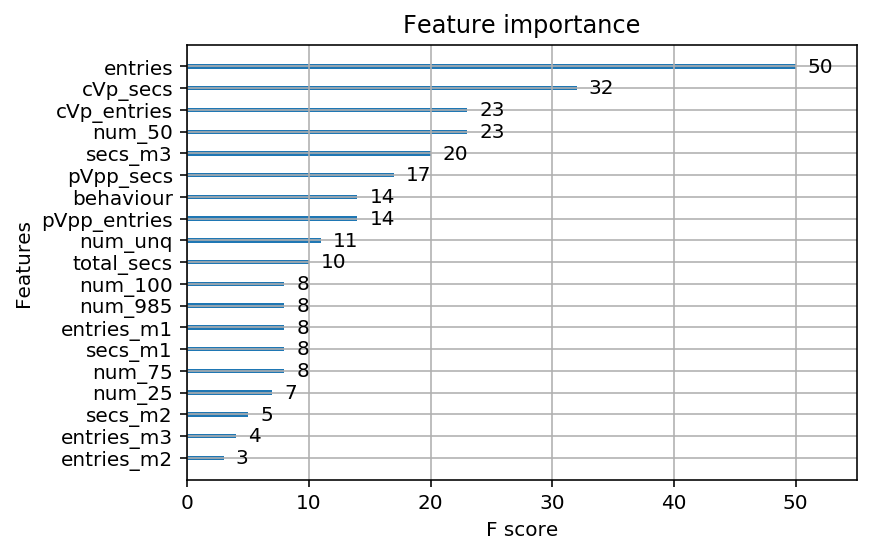

XGB Time = 54
(probs) Logloss for XGD Boost is: 0.305715


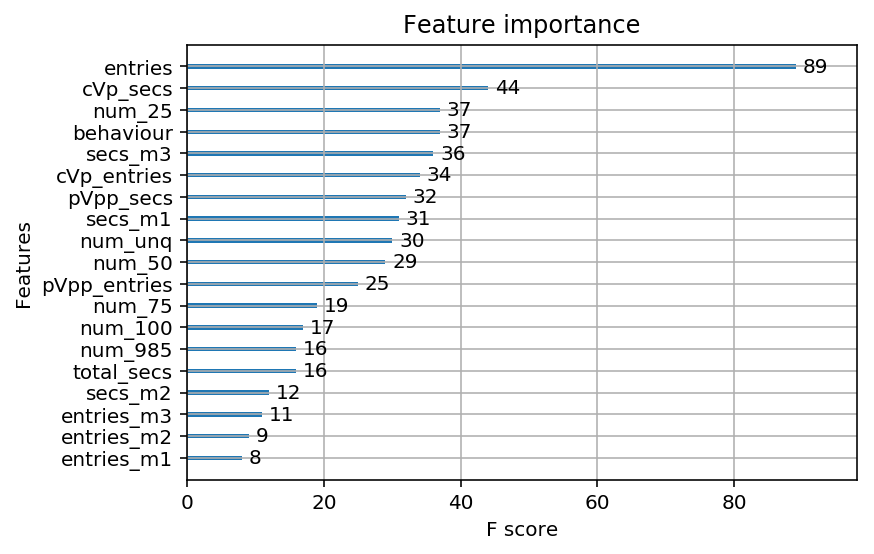

XGB Time = 313


In [ ]:
xgb_boost(ul_1,ul_2,1,3,0.3,20)
xgb_boost(ul_1,ul_2,1,3,0.3,40)
xgb_boost(ul_1,ul_2,1,3,0.1,400)
print('### over-fitting check: ###')
#xgb_boost(ul_sample_1,ul_sample_1)

We run XG Boost 3 times using different parameters:
(COMMENT: Explanation of the parameters needs to be given!)
1. depth = 3, eta = 0.3, num_round = 20: XG Boost only takes 54 seconds and yields a logloss of 0.30
2. depth = 3, eta = 0.3, num_round = 40: XG Boost takes 313 and also yields a logloss of around 0.30
3. depth = 3, eta = 0.1, num_round = 400: 

For XG Boost we don't have to worry about over-fitting, as the algorithm takes care of that.

In [ ]:
# AdaBoost
def ada_b(train,test):
    start = time.time()
    if ('msno' in train.columns):
        train = train.drop('msno',axis=1)
    if ('msno' in test.columns):
        test = test.drop('msno',axis=1)
    X_train = train.drop('is_churn',axis=1)
    y_train = train['is_churn']
    X_test = test.drop('is_churn',axis=1)
    y_test = test['is_churn']
    
    model_abr = AdaBoostRegressor()
    model_abr.fit(X_train, y_train)
    y_pred_abr = model_abr.predict(X_test)
    print("Logloss for AdaBoost is: %.6f"%log_loss(y_test,y_pred_abr))
    
    print('Ada Time = %.0f'%time.time() - start)

In [ ]:
ada_b(ul_1,ul_2)
print('### over-fitting check: ###')
ada_b(ul_1,ul_1)

AdaBoost gives a logloss of around 0.30, so it is also one of the better alternatives.

COMMENT: In this function I implemented a Cross-Validation method - can be useful for the report

In [89]:
# Neural Network
def neural(train,test,cv):
    start = time.time()
    if ('msno' in train.columns):
        train = train.drop('msno',axis=1)
    if ('msno' in test.columns):
        test = test.drop('msno',axis=1)
    X_train = train.drop('is_churn',axis=1)
    y_train = train['is_churn']
    X_test = test.drop('is_churn',axis=1)
    y_test = test['is_churn']

    model_n = MLPClassifier()
    model_n.fit(X_train, y_train)
    y_pred_n = model_n.predict(X_test)
    
    print("Logloss for Neural Network is: %.6f"%log_loss(y_test,y_pred_n)) 
    
    if (cv == 1):
        cv = ShuffleSplit(n_splits=3, test_size=0.33, random_state=42)
        scores = cross_val_score(model_n, data_input, data_output, cv=cv, scoring='log_loss')
        #scores = - scores
        print(scores)
        print("CV log loss: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    
    print('Neural Time = %.0f'%(time.time() - start))

In [90]:
neural(ul_1,ul_2,0)
print('### over-fitting check: ###')
neural(ul_1,ul_1,0)

Logloss for Neural Network is: 9.539522
Neural Time = 2
### over-fitting check: ###
Logloss for Neural Network is: 9.952399
Neural Time = 2


The neural network MLPClassifier is very ineffective for our problem and will not be used for testing further on.

From the above observations, we can already conclude that XGBoost, Adaboost and Linear Regression are the most performing algorithms for this dataset. As we will presumably also use one of them for our final solution, tweaks on features in this dataset will mostly by tested with those algorithms.

### 3.3.2 Testing features
We will now apply a bunch of different procedures, like removing features or changing them.
#### i) First, let's have a look at our current columns and their correlation:
We will look for features having high correlation and remove the ones that are correlated by more than 0.8 (pearson coefficient) to another one.

In [ ]:
# Correlation heat map
sns.heatmap(ul_1.drop(columns=['msno','is_churn'],axis=1).corr(), annot=False, fmt=".2f",center=1.3)
plt.show()

We can see that some features have really strong correlation. Let's identify them and remove those that have a higher correlation than 0.8.

In [25]:
ul_1_nocorr = ul_1.copy()
ul_2_nocorr = ul_2.copy()

print(np.corrcoef(ul_2['num_75'],ul_2['num_50'])[0][1])
print(np.corrcoef(ul_2['num_unq'],ul_2['num_100'])[0][1])
print(np.corrcoef(ul_2['num_unq'],ul_2['num_100'])[0][1])
print(np.corrcoef(ul_2['entries_m1'],ul_2['entries_m2'])[0][1])
print(np.corrcoef(ul_2['secs_m1'],ul_2['secs_m2'])[0][1])
print(np.corrcoef(ul_2['num_50'],ul_2['num_25'])[0][1])
print(np.corrcoef(ul_2['cVp_entries'],ul_2['cVp_secs'])[0][1])

# thus we remove num_75, num_unq, entries_m2, secs_m2
del ul_1_nocorr['num_75']
del ul_2_nocorr['num_75']
del ul_1_nocorr['num_unq']
del ul_2_nocorr['num_unq']
del ul_1_nocorr['entries_m2']
del ul_2_nocorr['entries_m2']
del ul_1_nocorr['secs_m2']
del ul_2_nocorr['secs_m2']


0.9397726457104911
0.9115701835036264
0.9115701835036264
0.8775064500069794
0.8682164404376238
0.795670084171738
0.6859188242206229


### original ###

### per log ###
Logloss for Linear Regression is: 0.305543
(probs) Logloss for XGD Boost is: 0.304976


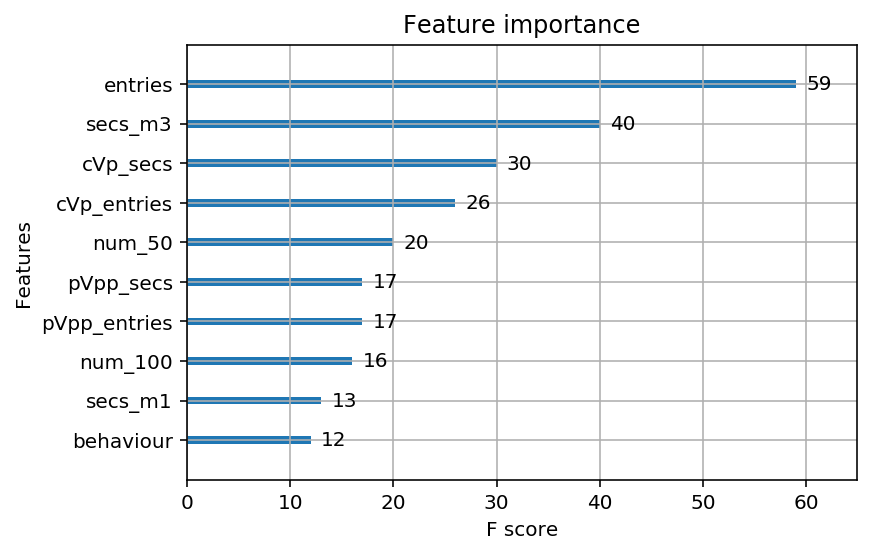

XGB Time = 6
Logloss for AdaBoost is: 0.306413
Time = 1.2148118019104004


In [26]:
print('\n### per log ###')
lin_reg(ul_1_nocorr,ul_2_nocorr)
xgb_boost(ul_1_nocorr,ul_2_nocorr,1,3,0.3,20)
ada_b(ul_1_nocorr,ul_2_nocorr)


The result did not change and thus we will not change our data.

#### ii) Chaning num-.. columns to 'per log' basis

We change the num-.. columns so that they represent the amount of songs listened to per log instead of an absolute number.

In [102]:
ul_pl_1 = ul_1.copy()
ul_pl_2 = ul_2.copy()

# changing num's to 'per log'
num_columns = ['num_25','num_50','num_75','num_985','num_100','num_unq']
for i in range(0,len(num_columns)):
    inpt = num_columns[i]
    idx1 = (ul_pl_1['entries'] != 0)
    ul_pl_1[inpt][idx1] = ul_pl_1[inpt][idx1]/ul_pl_1['entries'][idx1]
    ul_pl_1[inpt][~idx1] = ul_pl_1[inpt]
    
    idx2 = (ul_pl_2['entries'] != 0)
    ul_pl_2[inpt][idx2] = ul_pl_2[inpt][idx2]/ul_pl_2['entries'][idx2]
    ul_pl_2[inpt][~idx2] = ul_pl_2[inpt]       
        
print(ul_pl_2.isnull().sum())


# Predictions
print('\n### per log ###')
lin_reg(ul_pl_1,ul_pl_2)
ada_b(ul_pl_1,ul_pl_2)
xgb_boost(ul_pl_1,ul_pl_2,0,3,0.3,20)


/Users/maximekayser/miniconda3/envs/kkbox/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/maximekayser/miniconda3/envs/kkbox/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/maximekayser/miniconda3/envs/kkbox/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-

msno           0
entries        0
entries_m2     0
entries_m1     0
num_100        0
num_25         0
num_50         0
num_75         0
num_985        0
num_unq        0
secs_m2        0
secs_m1        0
total_secs     0
behaviour      0
is_churn       0
cVp_entries    0
cVp_secs       0
dtype: int64

### per log ###
Logloss for Linear Regression is: 0.304589
Model fitted!
Logloss for AdaBoost is: 0.304688
Time = 1.6266088485717773
(probs) Logloss for XGD Boost is: 0.304957
XGB Time = 6


Logloss didn't improve for either of the algorithms, so we don't change our data.

#### iii) Z-scoring and max-normalization

As the different features in user_logs data have very different number ranges, normalization might have positive impact.

In [104]:
# max normalization
train_norm = ul_1.drop(columns=['is_churn','msno'],axis=1)
train_norm = (train_norm - train_norm.min())/(train_norm.max() - train_norm.min())
train_norm['is_churn'] = ul_1['is_churn']
train_norm['msno'] = ul_1['msno']

test_norm = ul_2.drop(columns=['is_churn','msno'],axis=1)
test_norm = (test_norm-test_norm.min())/(test_norm.max()-test_norm.min())
test_norm['is_churn'] = ul_2['is_churn']
test_norm['msno'] = ul_2['msno']

print('\n### max-normalization ###')
lin_reg(train_norm,test_norm)
ada_b(train_norm,test_norm)
xgb_boost(train_norm,test_norm,0,3,0.2,20)



### max-normalization ###
Logloss for Linear Regression is: 0.306777
Model fitted!
Logloss for AdaBoost is: 0.306190
Time = 0.9012441635131836
(probs) Logloss for XGD Boost is: 0.305375
XGB Time = 5


No improvements, so we won't apply the changes.

In [105]:
# z-scoring
train_z = ul_1.drop(columns=['is_churn','msno'],axis=1)
train_z =(train_z - train_z.mean())/train_z.std()
train_z['is_churn'] = ul_1['is_churn']

test_z = ul_2.drop(columns=['is_churn','msno'],axis=1)
test_z =(test_z - test_z.mean())/test_z.std()
test_z['is_churn'] = ul_2['is_churn']

print('\n### z-scoring ###')
lin_reg(train_z,test_z)
ada_b(train_z,test_z)
xgb_boost(train_z,test_z,0,3,0.3,20)



### z-scoring ###
Logloss for Linear Regression is: 0.305973
Model fitted!
Logloss for AdaBoost is: 0.307797
Time = 1.5739729404449463
(probs) Logloss for XGD Boost is: 0.305193
XGB Time = 6


No improvements, so we won't apply the changes.

#### iv) Removing any feature individually
=> see explanation in Rick's member file

In [106]:
# columns selection
eng_columns = np.array(list(ul_1.drop(columns=['is_churn','msno'],axis=1)))

for i in range(0,len(eng_columns)):
    inpt = eng_columns[i]
    data_input = ul_1.drop(inpt,axis=1)
    data_outupt = ul_2.drop(inpt,axis=1)
    print('\n###',inpt,'removed ###')
    lin_reg(data_input,data_outupt)
    ada_b(data_input,data_outupt)
    xgb_boost(data_input,data_outupt,0,3,0.3,20)



### entries removed ###
Logloss for Linear Regression is: 0.305695
Model fitted!
Logloss for AdaBoost is: 0.306240
Time = 0.8451972007751465
(probs) Logloss for XGD Boost is: 0.305093
XGB Time = 5

### entries_m2 removed ###
Logloss for Linear Regression is: 0.306143
Model fitted!
Logloss for AdaBoost is: 0.306225
Time = 1.523094892501831
(probs) Logloss for XGD Boost is: 0.305167
XGB Time = 5

### entries_m1 removed ###
Logloss for Linear Regression is: 0.307423
Model fitted!
Logloss for AdaBoost is: 0.306289
Time = 1.127856969833374
(probs) Logloss for XGD Boost is: 0.305122
XGB Time = 5

### num_100 removed ###
Logloss for Linear Regression is: 0.305442
Model fitted!
Logloss for AdaBoost is: 0.310361
Time = 0.7572808265686035
(probs) Logloss for XGD Boost is: 0.305295
XGB Time = 5

### num_25 removed ###
Logloss for Linear Regression is: 0.305437
Model fitted!
Logloss for AdaBoost is: 0.306213
Time = 0.8010690212249756
(probs) Logloss for XGD Boost is: 0.305416
XGB Time = 5

### nu

Removing a single feature doesn't make any differece.

#### v) Trying every feature on their own

Below we will discover that each and every feature individually will perform better than all the features together. What is very strange, is that each feature, whereas some appear to us to be much more relevant than others, all have up to 0.01 the exact same logloss (also for the different three algorithms). COMMENT: THIS IS THE PART WHERE IT IS MOST OBVIOUS THAT WE HAVE A BUG AND IT'S ALSO HARD TO HIDE SO I WOULD REMOVE IT! also for Rick's file)

In [107]:
# columns selectione
eng_columns = np.array(list(ul_1.drop(columns=['is_churn','msno'],axis=1)))

for i in range(0,len(eng_columns)):
    inpt = eng_columns[i]
    data_input = ul_1[[inpt,'is_churn']]
    data_output = ul_1[[inpt,'is_churn']]
    print('\n###',inpt,'###')
    lin_reg(data_input,data_output)
    ada_b(data_input,data_output)
    xgb_boost(data_input,data_output,0,3,0.3,20)



### entries ###
Logloss for Linear Regression is: 0.240377
Model fitted!
Logloss for AdaBoost is: 0.239470
Time = 0.43063783645629883
(probs) Logloss for XGD Boost is: 0.238897
XGB Time = 1

### entries_m2 ###
Logloss for Linear Regression is: 0.240285
Model fitted!
Logloss for AdaBoost is: 0.239852
Time = 0.09644079208374023
(probs) Logloss for XGD Boost is: 0.239817
XGB Time = 1

### entries_m1 ###
Logloss for Linear Regression is: 0.240746
Model fitted!
Logloss for AdaBoost is: 0.240505
Time = 0.15541291236877441
(probs) Logloss for XGD Boost is: 0.240459
XGB Time = 1

### num_100 ###
Logloss for Linear Regression is: 0.241186
Model fitted!
Logloss for AdaBoost is: 0.240676
Time = 0.21412086486816406
(probs) Logloss for XGD Boost is: 0.239429
XGB Time = 1

### num_25 ###
Logloss for Linear Regression is: 0.240953
Model fitted!
Logloss for AdaBoost is: 0.240574
Time = 0.1384601593017578
(probs) Logloss for XGD Boost is: 0.240028
XGB Time = 1

### num_50 ###
Logloss for Linear Regres